# Variational AutoEncoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
import numpy as np
import tensorflow as tf

from tensorflow.distributions import Normal
from tensorflow.distributions import Bernoulli

'''A Variational Auto Encoder using TensorFlow'''

class VariationalAutoencoder:
    
    def __init__(self, n_input, n_list):
        '''
        number of input neurons and a list of the number of neurons in the encoder hidden layers
            The last number provided should be the number of latent features desired
                
        The decoder will have an inverted architecture
        
        Note: the actual number of neurons in the last layer of the encoder will be x2, for mean and std
            '''
        # input data
        self.X = tf.placeholder(tf.float32, shape=(None, n_input))
        self.y = tf.placeholder(tf.float32,shape=(None,2))
        
        # encoder
        self.encoder_layers = []
        # input layer
        previous = n_input
        # current is the output of each layer (skip last because there is nothing after it)
        for current in n_list[:-1]:
            h = DenseLayer(previous,current)
            self.encoder_layers.append(h)
            previous = current
        # latent features number
        latent = n_list[-1]
        encoder_output = DenseLayer(current,latent*2,activation='none')
        self.encoder_layers.append(encoder_output)
        
        # feed forward through encoder
        c_X = self.X
        for layer in self.encoder_layers:
            c_X = layer.feed_forward(c_X)
        # c_X now holds the output of the encoder
        # first half are the means
        self.means = c_X[:,:latent]
        # second half are the std; must be positive; +1e-6 for smoothing
        self.std = tf.nn.softplus(c_X[:,latent:]) + 1e-6
        
        self.yhat = self.means[:,:2]
        self.weight = tf.Variable(0.0)
        self.error = tf.math.scalar_mul(self.weight,
                                        tf.losses.mean_squared_error(labels=self.y, predictions=self.yhat))
        
        # reparameterization trick
        normal = Normal(loc=self.means,scale=self.std)
        self.Z = normal.sample()
                
        # decoder
        self.decoder_layers = []
        previous = latent
        for current in reversed(n_list[:-1]):
            h = DenseLayer(previous,current)
            self.decoder_layers.append(h)
            previous = current
        # output is the reconstruction
        decoder_output = DenseLayer(previous,n_input,activation=lambda x:x)
        self.decoder_layers.append(decoder_output)

        #feed forward through decoder, using the sampled 'data'
        c_X = self.Z
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        # use logits for cost function below
        neg_cross_entropy = -tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X,
                    logits=logits)
        neg_cross_entropy = tf.reduce_sum(neg_cross_entropy, 1)
        
        # output
        self.y_prob = Bernoulli(logits=logits)
        
        # sample from output
        self.post_pred = self.y_prob.sample()
        self.post_pred_probs = tf.nn.sigmoid(logits)
        
        # generate 'de-novo' output
        self.gen = tf.Variable(0)
        Z_std = Normal(0.0,1.0).sample([self.gen,latent])
        c_X = Z_std
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        
        prior_pred_dist = Bernoulli(logits=logits)
        self.prior_pred = prior_pred_dist.sample()
        self.prior_pred_probs = tf.nn.sigmoid(logits)
        
        # manually input Z
        self.Z_input = tf.placeholder(np.float32, shape=(None, latent))
        c_X = self.Z_input
        for layer in self.decoder_layers:
            c_X = layer.feed_forward(c_X)
        logits = c_X
        self.manual_prior_prob = tf.nn.sigmoid(logits)
        
        # cost function
        # Kullback–Leibler divergence
        kl = -tf.log(self.std) + 0.5*(self.std**2 + self.means**2) - 0.5
        kl = tf.reduce_sum(kl, axis=1)
        # ELBO
        self.elbo = tf.reduce_sum(neg_cross_entropy - kl) 
        
        self.optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-self.elbo + self.error)
               
        self.init = tf.global_variables_initializer()
        self.session = tf.Session()
        self.session.run(self.init)
        
    def fit(self,X,y,epochs=10,batch=50):
        n_batches = len(X) // batch
        for epoch in range(epochs):
            print('Epoch:',epoch+1)
            np.random.shuffle(X)
            cost = 0
            for b in range(n_batches):
                c_batch = X[b*batch:(b+1)*batch]
                y_batch = y[b*batch:(b+1)*batch]
                _,c, = self.session.run((self.optimizer, self.elbo),feed_dict={self.X: c_batch,self.y: y_batch})
                # accumulate cost
                cost+=c
            print('Cost:', cost)
            
    def predict(self,X,out='prob'):
        '''
        Pass data through encoder and decoder and retrieve reconstructed output
            by default the probabilities are returned, user can specify 'sample' or 'both'
        '''
        # correct shape if needed
        if (X.ndim==1):
            X = X.reshape([1,-1])
        pred,prob = self.session.run((self.post_pred,self.post_pred_probs),feed_dict={self.X:X})
        if (out=='prob'):
            return prob
        elif (out=='sample'):
            return pred
        else:
            return pred,prob

    def generate(self,n=1,out='prob'):
        '''
        Generate output
            by default the probabilities are returned, user can specify 'sample' or 'both'
            User specifies the number of points requested 
        '''
        pred,prob = self.session.run((self.prior_pred,self.prior_pred_probs),feed_dict={self.gen:n})
        if (out=='prob'):
            return prob
        elif (out=='sample'):
            return pred
        else:
            return pred,prob
    
    def feed(self,Z):
        '''Generate output using provided latent-space input Z'''
        # correct shape if needed
        if (Z.ndim==1):
            Z = Z.reshape([1,-1])
        return self.session.run(self.manual_prior_prob,feed_dict={self.Z_input:Z})
    
    def close(self):
        self.session.close()

class DenseLayer(object):
    '''A fully connected layer'''
    
    def __init__(self, n_in, n_out, activation=tf.nn.relu):
        '''number of input and output neurons; the activation function'''
        self.weights = tf.Variable(tf.random_normal(shape=(n_in, n_out), stddev=2/np.sqrt(n_in)))
        self.bias = tf.Variable(tf.constant(0.0,shape=[n_out]))
        if (activation=='none'):
            self.activation = lambda x: x
        else:
            self.activation = activation
            
    def feed_forward(self, X):
        '''Run input through layer and retrieve output'''
        return self.activation(tf.matmul(X, self.weights) + self.bias)


### Generate data

In [3]:
size = 100000
d = 12

center = np.random.randint(1,d-1,size=(size,2))
height = np.random.randint(1,d//2-1,size=size)
width =  np.random.randint(1,d//2-1,size=size)

X = np.zeros((size,d,d),dtype=int)
y = np.zeros((size,2),dtype=int)

# paint rectangles
for i in range (len(X)):
    left = min(max(center[i,0]-width[i]//2,0),d-1)
    right = min(max(center[i,0]+width[i]//2,0),d-1)
    top = min(max(center[i,1]+height[i]//2,0),d-1)
    bottom = min(max(center[i,1]-height[i]//2,0),d-1)
    # fix single lines
    if abs(left-right) < 3:
        if (left>0):
            left-=1
        if (right<d-1):
            right+=1
    if abs(bottom-top) < 3:
        if (bottom>0):
            bottom-=1
        if (top<d-1):
            top+=1
    X[i,top,left:right+1] = 1
    X[i,bottom,left:right] = 1
    X[i,bottom:top,left] = 1
    X[i,bottom:top,right] = 1
    y[i,0] = abs(left-right)+1
    y[i,1] = abs(top-bottom)+1
    
# normalize y
y = (y - y.mean(axis=0)) / y.std(axis=0)

[0.76489636 0.76123308]


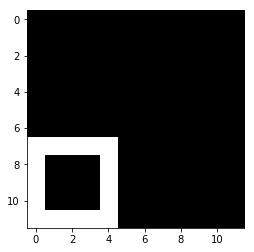

In [4]:
i = np.random.choice(range(len(X)))
print(y[i])
plt.imshow(X[i],cmap='gray')
plt.show()

In [8]:
# flatten
X = X.reshape(size,-1)
X.shape

(100000, 144)

### Generate and train encoder

In [14]:
vae = VariationalAutoencoder(144, [48,4])

** After several iterations, it finally converged and reconstructions were satisfactory **

In [ ]:
vae.fit(X,y,epochs=5)

In [17]:
vae.session.run((vae.optimizer, -vae.elbo, vae.error),feed_dict={vae.X:X,vae.y:y,vae.weight:1.0})

InvalidArgumentError: Input 0 of node RMSProp_1/update_Variable_34/ApplyRMSProp was passed float from _arg_Variable_34_0_2:0 incompatible with expected float_ref.

### Reconstruction

In [ ]:
fig,axes = plt.subplots(ncols=3,figsize=(16,16))

i = np.random.choice(len(X))
aa = vae.predict(X[i:i+3])
a = aa[0].reshape(d,d)
b = vae.predict(X[i],'sample').reshape(d,d)

print(y[i])
print(vae.session.run(vae.means,feed_dict={vae.X:X[i].reshape([1,-1])}))

axes[0].imshow(X[i].reshape(d,d),cmap='gray')
axes[0].set_title('original')
axes[1].imshow(a,cmap='gray')
axes[1].set_title('probability')
axes[2].imshow(b,cmap='gray')
axes[2].set_title('sample')
plt.show()

### Generation

In [ ]:
fig,axes = plt.subplots(ncols=4,figsize=(16,16))

c,dd = vae.generate(2,'both')
a,b = c[0].reshape(d,d), dd[0].reshape(d,d)
c,dd = c[1].reshape(d,d), dd[1].reshape(d,d)

axes[0].imshow(a,cmap='gray')
axes[0].set_title('sampled 1')
axes[1].imshow(b,cmap='gray')
axes[1].set_title('probability 1')
axes[2].imshow(c,cmap='gray')
axes[2].set_title('sampled 2')
axes[3].imshow(dd,cmap='gray')
axes[3].set_title('probability 2')
plt.show()

** Latent space contains values that map to non-square output, let's explore the latent space more carefully **

### Manual input to latent space

In [ ]:
Z_input = np.random.normal(size=(4,4))

fig,axes = plt.subplots(ncols=4,figsize=(16,16))

g = vae.feed(Z_input)
a,b = g[0].reshape(d,d), g[1].reshape(d,d)
c,dd = g[2].reshape(d,d), g[3].reshape(d,d)

axes[0].imshow(a,cmap='gray')
axes[1].imshow(b,cmap='gray')
axes[2].imshow(c,cmap='gray')
axes[3].imshow(dd,cmap='gray')
plt.show()

### Observe latent space

In [ ]:
grid = 7
xs = np.linspace(-3, 3, grid)
ys = np.linspace(-3, 3, grid)
latent = np.empty((d * grid, d * grid))

manual_Z = []
for x in xs:
    for y in ys:
        manual_Z.append([x,y,3,0])
        
manual_Z = np.array(manual_Z)
g = vae.feed(manual_Z)

for x in range(grid):
    for y in range(grid):
        idx = x+y*grid
        current = g[idx].reshape(d,d)
        latent[x*d:(x+1)*d,y*d:(y+1)*d] = current
        latent[x*d,:] = 1
        latent[:,y*d] = 1

plt.figure(figsize=(10,10))
plt.imshow(latent,cmap='gray')
plt.show()

x = 0 and y = 1 provides a good starting point (latent features 0 and 1)

In [ ]:
grid = 7
xs = np.linspace(-3, 3, grid)
ys = np.linspace(-6, 0, grid)
latent = np.empty((d * grid, d * grid))

manual_Z = []
for x in xs:
    for y in ys:
        manual_Z.append([0,1,x,y])
        
manual_Z = np.array(manual_Z)
g = vae.feed(manual_Z)

for x in range(grid):
    for y in range(grid):
        idx = x+y*grid
        current = g[idx].reshape(d,d)
        latent[x*d:(x+1)*d,y*d:(y+1)*d] = current
        latent[x*d,:] = 1
        latent[:,y*d] = 1

plt.figure(figsize=(10,10))
plt.imshow(latent,cmap='gray')
plt.show()

After slight adjustment to the range, it seems that within this setting, the latent space features 2 and 3 vaguely translate to position of the rectangle, but the features are mixed with other characteristics as well